In [1]:
import os
import sys

MODULE_PATH = '/content/drive/MyDrive/GitHub/DL_Study/CNN'

sys.path.insert(0, MODULE_PATH)
sys.path

['/content/drive/MyDrive/GitHub/DL_Study/CNN',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [2]:
# import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy

from ShuffleNet import *

torch.manual_seed(42)

# for time series split
!pip install scikit-learn==0.24.2

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def np_to_tensor(data):
    device = get_device()
    return torch.tensor(data).float().to(device)

# configuration setting
def model_config():
    # parameter for CNN Model
    epochs = [30]
    batch_size = [64]
    learning_rate = [0.01, 0.001]
    
    # create config data
    configs = []
    for i in epochs:
        for j in batch_size:
            for k in learning_rate:
                config = [i, j, k]
                configs.append(config)
    return configs

# fucntion for fit cnn model using configs
def model_fit(train_X, train_y, config, verbose=0):

    # unpack config
    n_epochs, n_batch, learning_rate = config
    # use ShuffleNet for CNN
    model = ShuffleNet(groups=3, in_channels=1)
    if torch.cuda.is_available():
        model.cuda()

    # define Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    data_size = train_X.size(0)
    max_iters = data_size//n_batch

    for epoch in range(1, n_epochs+1):
        #shuffle data
        idx = numpy.random.permutation(numpy.arange(data_size))
        x_data = train_X[idx]
        y_data = train_y[idx]

        epoch_loss = 0
        start_time = time.time()
        for it in range(max_iters):
            batch_x = x_data[it*n_batch:(it+1)*n_batch]
            batch_y = y_data[it*n_batch:(it+1)*n_batch]

            optimizer.zero_grad()
            predict = model(batch_x)
            loss = criterion(predict, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss+= loss.item()
        avg_loss = epoch_loss/max_iters

        if verbose:
            duration = start_time-time.time()
            print(f'epoch:{epoch}/{epochs}, ì‹œê°„:{duration:.2f}[s], loss:{avg_loss:.5f}')


    return model

def MAE_metric(x, t):
    t = np.array(t)
    return np.mean(numpy.abs(x-t))

def MSE_metric(x, t):
    t = np.array(t)
    return np.mean((x-t)**2)

In [4]:
import pandas as pd
import numpy as np
import numpy
import urllib.request
import io
from scipy.io import arff

numpy.random.seed(42)

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
ftpstream = urllib.request.urlopen(data_url)
data = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))
df = pd.DataFrame(data[0])
df['eyeDetection'] = df['eyeDetection'].astype(str)
df['eyeDetection'].replace('(.*)0(.*)', '0', regex=True, inplace=True)
df['eyeDetection'].replace('(.*)1(.*)', '1', regex=True, inplace=True)
df['eyeDetection'] = df['eyeDetection'].astype(float)
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0.0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0.0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0.0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0.0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0.0


In [5]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

# jb = (n/6)*(skewness**2 + (kurtosis**2/4))

def data_statistics(df):
    df = df.dropna()
    data = df.values
    num = len(df)
    skewness_ = skew(data)
    kurtosis_ = kurtosis(data)
    jarque_bera_ = (num/6)*(skewness_**2 + (kurtosis_**2/4))
    result = adfuller(data)
    adf_ = result[0]
    print(f'skewness : {skewness_}')
    print(f'kurtosis : {kurtosis_}')
    print(f'jarque bera : {jarque_bera_}')
    print(f'ADF : {adf_}')

data_statistics(df['eyeDetection'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


skewness : 0.20588877122691596
kurtosis : -1.9576098138826705
jarque bera : 2497.7882491511805
ADF : -4.803113836889481


In [6]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [7]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

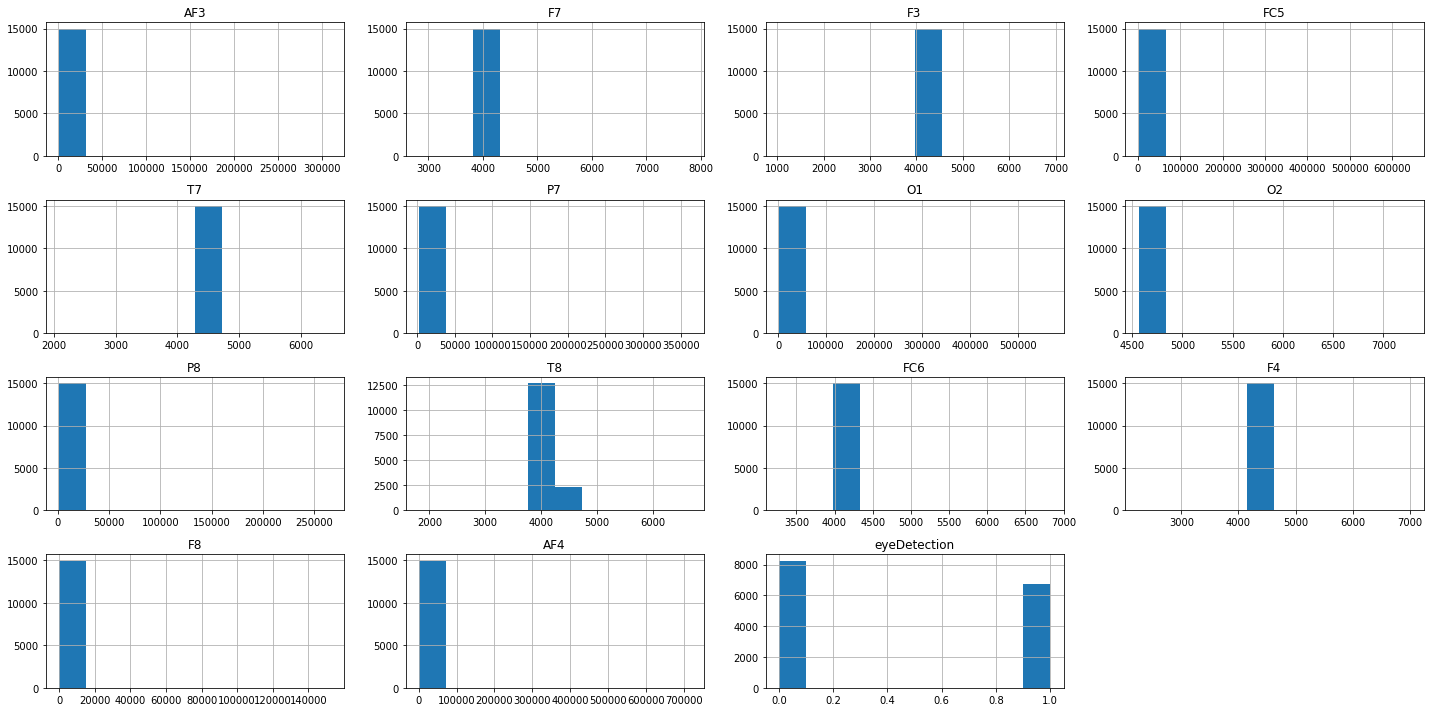

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

df.hist(figsize=(20, 10))
plt.tight_layout()
plt.show()

In [9]:
# series data to img function
def series_to_img(dataset, time_step=1):
    num = dataset.shape[1]      # features num
    df = pd.DataFrame(dataset)
    cols, names = list(), list()
    # sequence t-n to t-1
    for i in range(time_step, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num)]

    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

dataset = df.values
dataset = dataset.astype('float')

n_inputs = 24
n_features = 14
del_idx = n_inputs * (n_features + 1)
del_cols = [i for i in range(n_features, del_idx, n_features+1)]
del_cols += [i for i in range(del_idx-1, del_idx+n_features)]
new_df = series_to_img(dataset, n_inputs)
new_df.drop(new_df.columns[del_cols], axis=1, inplace=True)
new_df.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),var11(t-24),var12(t-24),var13(t-24),var14(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),var6(t-23),var7(t-23),var8(t-23),var9(t-23),var10(t-23),var11(t-23),var12(t-23),var13(t-23),var14(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),var5(t-22),var6(t-22),var7(t-22),var8(t-22),var9(t-22),var10(t-22),var11(t-22),var12(t-22),...,var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t)
24,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,...,4132.31,4343.08,4587.18,4091.79,4617.95,4213.33,4240.51,4217.95,4274.36,4632.31,4400.51,4331.28,4024.10,4266.15,4140.00,4336.41,4585.64,4089.74,4617.95,4204.62,4245.13,4216.41,4274.36,4638.97,4401.54,4326.67,4020.00,4264.10,4137.44,4334.36,4586.15,4088.21,4621.54,4213.33,4238.46,4208.72,4271.28,4634.36,4385.13,0.0
25,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,...,4140.00,4336.41,4585.64,4089.74,4617.95,4204.62,4245.13,4216.41,4274.36,4638.97,4401.54,4326.67,4020.00,4264.10,4137.44,4334.36,4586.15,4088.21,4621.54,4213.33,4238.46,4208.72,4271.28,4634.36,4385.13,4321.54,4007.69,4260.00,4132.31,4340.00,4585.64,4087.18,4630.26,4230.26,4242.56,4208.72,4270.26,4627.69,4378.97,0.0
26,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,...,4137.44,4334.36,4586.15,4088.21,4621.54,4213.33,4238.46,4208.72,4271.28,4634.36,4385.13,4321.54,4007.69,4260.00,4132.31,4340.00,4585.64,4087.18,4630.26,4230.26,4242.56,4208.72,4270.26,4627.69,4378.97,4317.44,4007.69,4257.44,4128.72,4343.59,4585.13,4088.21,4638.97,4231.79,4247.69,4209.23,4269.74,4625.13,4386.15,0.0
27,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,4321.03,4004.62,4284.10,4153.33,4345.64,4587.18,4093.33,4616.92,4202.56,4232.82,4209.74,4281.03,...,4132.31,4340.00,4585.64,4087.18,4630.26,4230.26,4242.56,4208.72,4270.26,4627.69,4378.97,4317.44,4007.69,4257.44,4128.72,4343.59,4585.13,4088.21,4638.97,4231.79,4247.69,4209.23,4269.74,4625.13,4386.15,4311.79,4007.18,4250.77,4125.13,4336.41,4587.18,4087.69,4634.36,4209.23,4232.31,4197.44,4262.05,4615.38,4381.03,0.0
28,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,4321.03,4004.62,4284.10,4153.33,4345.64,4587.18,4093.33,4616.92,4202.56,4232.82,4209.74,4281.03,4628.21,4389.74,4319.49,4001.03,4280.51,4151.79,4343.59,4584.62,4089.74,4615.90,4212.31,4226.67,4201.03,4269.74,...,4128.72,4343.59,4585.13,4088.21,4638.97,4231.79,4247.69,4209.23,4269.74,4625.13,4386.15,4311.79,4007.18,4250.77,4125.13,4336.41,4587.18,4087.69,4634.36,4209.23,4232.31,4197.44,4262.05,4615.38,4381.03,4308.72,4000.00,4245.13,4121.

In [10]:
n_splits = 10
train_test_split = TimeSeriesSplit(n_splits=n_splits+1, gap=n_inputs).split(new_df)
next(train_test_split)

configs = model_config()
history = []

best_rmse, best_mse, best_mae = [], [], []

i = 1

print('config : epochs, batch_size, learning_rate')

# nested cross validation for time series model
for train_cv_indices, test_cv_indices in train_test_split:
    print(f'fold : {i}/{n_splits}')
    i+=1

    # split x, y data
    train_cv_X, train_cv_y = new_df.iloc[train_cv_indices, :-1].values, new_df.iloc[train_cv_indices,-1].values
    test_cv_X, test_cv_y = new_df.iloc[test_cv_indices, :-1].values, new_df.iloc[test_cv_indices, -1].values

    # length for validation set
    test_length = int(len(train_cv_X)*0.2)

    # scaling data
    scaler_x = MinMaxScaler()
    train_cv_X = scaler_x.fit_transform(train_cv_X)
    test_cv_X = scaler_x.transform(test_cv_X)

    train_X, val_X = train_cv_X[:-test_length, :], train_cv_X[-test_length:, :]
    train_y, val_y = train_cv_y[:-test_length], train_cv_y[-test_length:]

    # reshape
    # inner loop
    train_X = train_X.reshape(-1, 1, n_inputs, n_features)
    val_X = val_X.reshape(-1, 1, n_inputs, n_features)
    train_y = train_y.reshape(-1, 1)
    val_y = val_y.reshape(-1, 1)

    # outer loop
    train_cv_X = train_cv_X.reshape(-1, 1, n_inputs, n_features)
    test_cv_X = test_cv_X.reshape(-1, 1, n_inputs, n_features)
    train_cv_y = train_cv_y.reshape(-1, 1)
    test_cv_y = test_cv_y.reshape(-1, 1)

    train_X = np_to_tensor(train_X)
    train_y = np_to_tensor(train_y)
    val_X = np_to_tensor(val_X)
    val_y = np_to_tensor(val_y)
    train_cv_X = np_to_tensor(train_cv_X)
    train_cv_y = np_to_tensor(train_cv_y)
    test_cv_X = np_to_tensor(test_cv_X)
    test_cv_y = np_to_tensor(test_cv_y)

    # model fit, inner
    errors = []
    for idx, cfg in enumerate(configs):
        print(f' == train {cfg} model == ', end=' ')
        model = model_fit(train_X, train_y, cfg)
        predicted = model(val_X)
        error = F.mse_loss(predicted, val_y)   # rmse
        print(f'error(rmse):{error.item():.2f}')
        if errors:
            if error.item() < min(errors):
                param = idx
        else:
            param = idx
        errors.append(error.item())

    history.append(errors)

    # outer
    selected_model = model_fit(train_cv_X,train_cv_y, configs[param])
    predicted = selected_model(test_cv_X)
    rmse = np.sqrt(F.mse_loss(predicted, test_cv_y).item())
    mse = F.mse_loss(predicted, test_cv_y)
    mae = F.l1_loss(predicted, test_cv_y)
    best_rmse.append(rmse)
    best_mse.append(mse.item())
    best_mae.append(mae.item())

    # model eval
    print(f'train-size:{train_X.size(0)}, val-size:{val_X.size(0)}, test-size:{test_cv_X.size(0)}')
    print(f'best_model => error(rmse) : {rmse:.2f}, param:{configs[param]}')
    print()

config : epochs, batch_size, learning_rate
fold : 1/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.52
 == train [30, 64, 0.001] model ==  error(rmse):0.53
train-size:1978, val-size:494, test-size:1246
best_model => error(rmse) : 0.58, param:[30, 64, 0.01]

fold : 2/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.35
 == train [30, 64, 0.001] model ==  error(rmse):0.34
train-size:2975, val-size:743, test-size:1246
best_model => error(rmse) : 0.73, param:[30, 64, 0.001]

fold : 3/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.37
 == train [30, 64, 0.001] model ==  error(rmse):0.37
train-size:3972, val-size:992, test-size:1246
best_model => error(rmse) : 0.65, param:[30, 64, 0.01]

fold : 4/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.53
 == train [30, 64, 0.001] model ==  error(rmse):0.54
train-size:4968, val-size:1242, test-size:1246
best_model => error(rmse) : 0.55, param:[30, 64, 0.01]

fold : 5/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.48
 == train [30, 64, 0.001] model ==  error(rmse):0.40
train-size:5965, val-size:1491, test-size:1246
best_model => error(rmse) : 0.71, param:[30, 64, 0.001]

fold : 6/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.43
 == train [30, 64, 0.001] model ==  error(rmse):0.46
train-size:6962, val-size:1740, test-size:1246
best_model => error(rmse) : 0.73, param:[30, 64, 0.01]

fold : 7/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.46
 == train [30, 64, 0.001] model ==  error(rmse):0.51
train-size:7959, val-size:1989, test-size:1246
best_model => error(rmse) : 0.45, param:[30, 64, 0.01]

fold : 8/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.41
 == train [30, 64, 0.001] model ==  error(rmse):0.53
train-size:8956, val-size:2238, test-size:1246
best_model => error(rmse) : 0.54, param:[30, 64, 0.01]

fold : 9/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.21
 == train [30, 64, 0.001] model ==  error(rmse):0.33
train-size:9952, val-size:2488, test-size:1246
best_model => error(rmse) : 0.56, param:[30, 64, 0.01]

fold : 10/10
 == train [30, 64, 0.01] model ==  

/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:218: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:220: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:222: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:223: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:225: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/drive/MyDrive/GitHub/DL_Study/CNN/ShuffleNet.py:227: UserWarning: nn.init.constant is now deprecated in favor of

error(rmse):0.32
 == train [30, 64, 0.001] model ==  error(rmse):0.39
train-size:10949, val-size:2737, test-size:1246
best_model => error(rmse) : 0.67, param:[30, 64, 0.01]



In [12]:
predicted = selected_model(test_cv_X)

def model_evaluation(mse, rmse, mae):
    mse = np.array(mse)
    rmse = np.array(rmse)
    mae = np.array(mae)
    print(f'MSE: mean={np.mean(mse)}, std={np.std(mse)}')
    print(f'RMSE: mean={np.mean(rmse)}, std={np.std(rmse)}')
    print(f'MAE: mean={np.mean(mae)}, std={np.std(mae)}')

model_evaluation(best_mse, best_rmse, best_mae)

MSE: mean=0.38779241144657134, std=0.10952568537972447
RMSE: mean=0.6161425683116648, std=0.09033685272842276
MAE: mean=0.49171660244464876, std=0.0834163865820588
